# Implementation of the paper ***'A ConvNet of the 2020s'*** published by *Zhuang Liu, Hanzi Mao, Chao-Yuan Wu, Christoph Feichtenhofer, Trevor Darrell, Saining Xie, Facebook AI Research (FAIR), UC Berkeley* on the 10 January 2022

*We'll start by importing the essential libraries*

In [1]:
import torchvision
import torch 
import datetime
from torch import nn
import torch.nn.functional as F
from torch import Tensor
from typing import List

*As described in the original papers we'll start from a simple ResNet and move gradually to our ConvNext basing on the archictecture of the Swin Transformer. Please refer to the research papers : https://arxiv.org/abs/2201.03545*

Let's sum up things to make them easier:

The architecture is as follow:


> ResNet-50

> Macro Design

> ResNext

> Inverted Bottleneck

> Large Kernel

> Micro Design

1.   We'll begin with the original ResNet-50 while considering an enhancement of capabilities by using some modern training procedures. Refer to this paper: https://openreview.net/pdf?id=NG6MJnVl6M5
2.   Next, we'll adjust the design of the number of blocks in each stage from regular ResNet(3-4-6-3) to 3-3-9-3 to approach similar FLOPs as in Swin Transformer and also replace the ResNet stem cell of (7,7 stride=2) with one of (4,4 stride=4) following the Swin Transformer.

3.   After that, we will mind use depthwise convolution effectively to reduce the network FLOPs by increasing the wifth if the network from 64 to 96.
2.   We'll also use **Inverted Bottleneck** by inversing the actual structure: 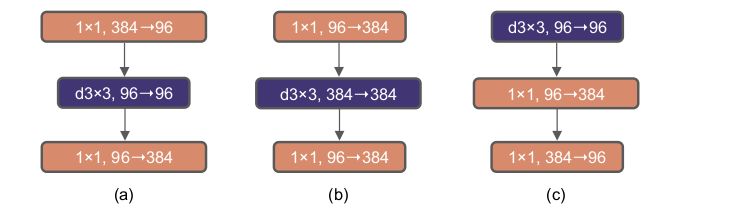
Going from a to c.
*figure: Picture originated from the original paper*

**Following this we must increase the kernel of the bottleneck from 3,3 to a larger one: 7,7**
4.   Finally we must use fewer activation functions and replace ReLU by GELU.

  Use fewer normalization layers by replacing BachNorm (BN) with   Layer Normalization (LN).

  And Add a (2,2 stride=2) spatial downsampling at the start of each state.
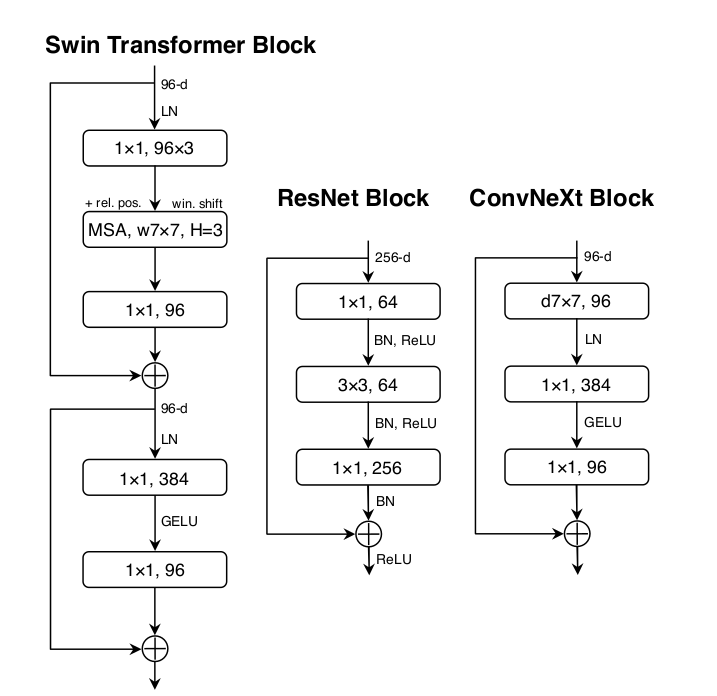



Let's define our ResNet block class first

In [2]:
# In the papers the authors started by a simple ResNet-50
# Firstly we will create a class for creating a simple Conv + Normalization + Activation

class FULLCONV(nn.Sequential):
  """
  We use nn.Sequential here rather than nn.Module
  because we won't have any method in this class
  """
  def __init__(self, in_channel: int, out_channel: int, kernel_size: int, norm = nn.BatchNorm2d, activation = nn.ReLU, **kwargs):
    """
    in_channel : The input feature size of the convolution
    out_channel : THe ouput feature size of the convolution
    kenel_size : size of the kernel (3 = (3, 3))
    norm : The normalization function, we use Batch Normalization for ResNet
    activation : The activation function, usually ReLU for ResNet
    """
    
    #Here we return a Conv + norm + act 
  
    super().__init__(
        nn.Conv2d(in_channel, out_channel, kernel_size = kernel_size, padding = kernel_size//2 , **kwargs),
        norm(out_channel),
        activation(),
    )

In [3]:
# Now we'll define our ResNet block class

class ResNet_block(nn.Module):
  """
  A class for returning the bottleneck
  bottleneck in ResNet is usually composed by:
  main_path:
    - (1, 1) Conv + Normalization + Activation
    - (3, 3) Conv + Normalization + Activation
    - (1, 1) Conv + Normalization
  short_path : (1, 1) Conv + Normalization
    ResNet_block = main_path + shortcut
  """
  def __init__(self, in_features: int, out_features: int, cardinality: int = 4, stride: int = 1,):
    """
    in_features = The input feature size
    out_features = The output features size
    cardinality = Use to control the reduction and expansion of input and output size through a stage
    stride = Essentially used to shrink the kernel size
    """
    super(ResNet_block, self).__init__()
    reduced = out_features//cardinality

    self.main_path = nn.Sequential(
        FULLCONV(in_features, reduced, kernel_size=1, stride=stride),
        FULLCONV(reduced, reduced, kernel_size=3),
        FULLCONV(reduced, out_features, kernel_size=1, activation = nn.Identity),
        # The Identity module returns the input without any manipulation applied
        # It will be useful for adding the short_path 
    )
    if in_features != out_features:
      self.short_path = nn.Sequential(
          FULLCONV(in_features, out_features, kernel_size=1, stride = stride)
      )

    else:
      self.short_path = nn.Identity()
    
    self.activation = nn.ReLU()

  def forward(self, x):
    residual = x
    x = self.main_path(x)
    residual = self.short_path(residual)
    x += residual
    x = self.activation(x)
    return x

In [4]:
x = torch.rand(1, 32, 7, 7)
block = ResNet_block(32, 64)
block(x).shape

torch.Size([1, 64, 7, 7])

*Right now we will define the stages in our ConvNeXt architecture*

**NB : The input_channels argument in the _stages() function represent the input feature size for a given stage**

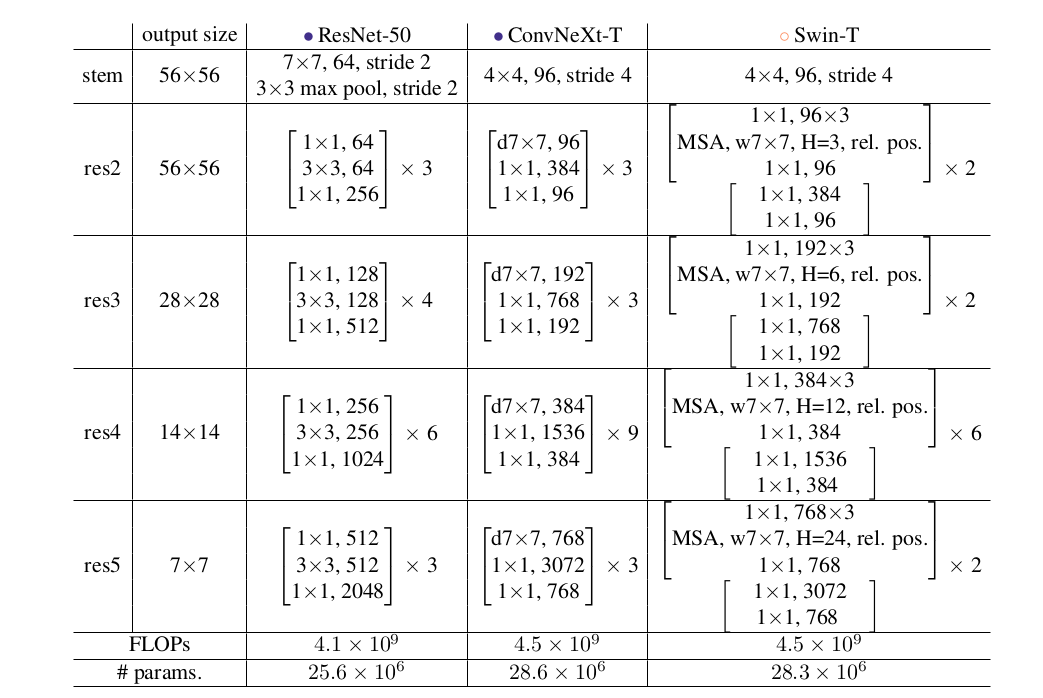

In [5]:
class ConvNeXt_stages(nn.Module):
  """
  Here is our stages class
  """
  def __init__(self, ResNet_block, stages_list):
    super().__init__()
    self.in_features = 96
    self.stage2 = self._stages(ResNet_block, stages_list[0], output_channel = 96)
    self.stage3 = self._stages(ResNet_block, stages_list[1], output_channel = 192)
    self.stage4 = self._stages(ResNet_block, stages_list[2], output_channel = 384)
    self.stage5 = self._stages(ResNet_block, stages_list[3], output_channel = 768)
  
  def forward(self, x):
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.stage5(x)
    return x


  def _stages(self, ResNet_block, residual_blocks, output_channel, stride : int = 2):
    stages_list = []

    # Here is the downsampling layer, It will downsample the input by a factor = 2
    stages_list.append(ResNet_block(self.in_features, output_channel,
                                    stride = stride)),* [stages_list.append(ResNet_block(output_channel,
                                                                                         output_channel)) for i in range(residual_blocks - 1)]
     
    
    return nn.Sequential(*stages_list)

In [6]:
ConvNeXt_stages(ResNet_block, [3,4,6,3])

ConvNeXt_stages(
  (stage2): Sequential(
    (0): ResNet_block(
      (main_path): Sequential(
        (0): FULLCONV(
          (0): Conv2d(96, 24, kernel_size=(1, 1), stride=(2, 2))
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): FULLCONV(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (2): FULLCONV(
          (0): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
      (short_path): Identity()
      (activation): ReLU()
    )
    (1): ResNet_block(
      (main_path): Sequential(
        (0): FULLCONV(
          (0): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d

In [7]:
out = ConvNeXt_stages(ResNet_block, [3,4,6,3])



*Let's implement the `stem` layer (This one which does the heavy downsampling of the input image)*

In [7]:
class ConvNeXt_stem(nn.Sequential):
  """
  Initially in ResNet, the stem layer is composed by
  a (7, 7) Conv + stride = 2 following with a MaxPool layer
  """
  def __init__(self, in_features: int, out_features: int, FULLCONV):
    super().__init__(
        FULLCONV(in_features, out_features, kernel_size = 7, stride = 2),
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    )

***So now we will sum up what we've done until here***

In [9]:
class ResNet_ConvNeXt(nn.Module):
  """
  The final ResNet-50 class before we make some
  adjustements from the macro and micro design
  """
  def __init__(self, in_channel, stem_feature, depth_list, ConvNeXt_stages, ResNet_block, FULLCONV, ConvNeXt_stem):
    """
    in_channel : The input channel size
    stem_feature: The output of the stem layer
    depth_list : The list of our stages
    """
    super(ResNet_ConvNeXt, self).__init__()
    self.stem = ConvNeXt_stem(in_channel, stem_feature, FULLCONV)
    self.stages_list = nn.ModuleList([ConvNeXt_stages(ResNet_block, depth_list)])
  
  def forward(self, x):
    x = self.stem(x)
    print(x.shape)
    for stage in self.stages_list:
      x = stage(x)
    return x

In [10]:
image = torch.rand(1, 3, 224, 224)
encoder = ResNet_ConvNeXt(3, 96, [3,3,9,3],ConvNeXt_stages, ResNet_block, FULLCONV, ConvNeXt_stem)
encoder

ResNet_ConvNeXt(
  (stem): ConvNeXt_stem(
    (0): FULLCONV(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stages_list): ModuleList(
    (0): ConvNeXt_stages(
      (stage2): Sequential(
        (0): ResNet_block(
          (main_path): Sequential(
            (0): FULLCONV(
              (0): Conv2d(96, 24, kernel_size=(1, 1), stride=(2, 2))
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (1): FULLCONV(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (2): FULLCONV(
  

***As our ResNet-50 is up, we will move to the Macro Design by changing the stage compute ration (3,4,6,3) --> (3,3,9,3)***

 ***And the stem to "Patchify" (7, 7) stride = 2 + MaxPool ---> (4, 4) stride = 4***

In [11]:
class ConvNeXt_stem(nn.Sequential):
  """
  Initially in ResNet, the stem layer is composed by
  a (7, 7) Conv + stride = 2 following with a MaxPool layer
  We replace this with a single (4, 4) Conv + stride = 4 layer
  """
  def __init__(self, in_features: int, out_features: int, FULLCONV, **kwargs):
    super().__init__(
        nn.Conv2d(in_features, out_features, kernel_size = 4, stride = 4, **kwargs),
        nn.BatchNorm2d(out_features),
    )

In [12]:
encoder = ResNet_ConvNeXt(3, 64, [3,3,9,3],ConvNeXt_stages, ResNet_block, FULLCONV, ConvNeXt_stem)

In [35]:
encoder

ResNet_ConvNeXt(
  (stem): ConvNeXt_stem(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages_list): ModuleList(
    (0): ConvNeXt_stages(
      (stage2): Sequential(
        (0): Sequential(
          (0): GroupNorm(1, 96, eps=1e-05, affine=True)
          (1): Conv2d(96, 96, kernel_size=(2, 2), stride=(2, 2))
        )
        (1): ResNet_block(
          (main_path): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): GroupNorm(1, 96, eps=1e-05, affine=True)
            (2): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
            (3): GELU()
            (4): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
          )
          (layer_scaler): LayerScaler()
          (drop_path): StochasticDepth(p=0.0, mode=batch)
        )
        (2): ResNet_block(
          (main_path): Sequential(
            

***By now we will use depth wise convolution, apply Inverted Bottleneck and Large kernel by the same time***

In [13]:
# Now we'll define our ResNet block class

class ResNet_block(nn.Module):
  """
  A class for returning the bottleneck
  bottleneck in ResNet is usually composed by:
  main_path:
    - (7, 7) Conv + Normalization + Activation
    - (1, 1) Conv + Normalization + Activation
    - (1, 1) Conv + Normalization
  short_path : (1, 1) Conv + Normalization
    ResNet_block = main_path + shortcut
  """
  def __init__(self, in_features: int, out_features: int, cardinality: int = 4, stride: int = 1,):
    """
    in_features = The input feature size
    out_features = The output features size
    cardinality = Use to control the reduction and expansion of input and output size through a stage
    stride = Essentially used to shrink the kernel size
    """
    super(ResNet_block, self).__init__()
    expansion = out_features*cardinality

    self.main_path = nn.Sequential(
        FULLCONV(in_features, in_features, kernel_size=7, stride=stride, padding = 3, groups = in_features),
        FULLCONV(in_features, expansion, kernel_size=1),
        FULLCONV(expansion, out_features, kernel_size=1, activation = nn.Identity),
        # The Identity module returns the input without any manipulation applied
        # It will be useful for adding the short_path 
    )
    if in_features != out_features:
      self.short_path = nn.Sequential(
          FULLCONV(in_features, out_features, kernel_size=1, stride = stride)
      )
    else:
      self.short_path = nn.Identity()
    
    self.activation = nn.ReLU()

  def forward(self, x):
    residual = x
    x = self.main_path(x)
    residual = self.short_path(residual)
    x += residual
    x = self.activation(x)
    return x

***From the micro design architecture we will replace ReLU by GELU, use fewer activation functions and fewer normalizing layers and also replace Bacth Normalization by Layer Normalization***

In [14]:
class ResNet_block(nn.Module):
  """
  A class for returning the bottleneck
  bottleneck in ResNet is usually composed by:
  main_path:()
    - (1, 1) Conv + Normalization + Activation
    - (3, 3) Conv + Normalization + Activation
    - (1, 1) Conv + Normalization
  short_path : (1, 1) Conv + Normalization
    ResNet_block = main_path + shortcut
  """
  def __init__(self, in_features: int, out_features: int, cardinality: int = 4, stride: int = 1,):
    """
    in_features = The input feature size
    out_features = The output features size
    cardinality = Use to control the reduction and expansion of input and output size through a stage
    stride = Essentially used to shrink the kernel size
    """
    super(ResNet_block, self).__init__()
    expansion = out_features*cardinality

    self.main_path = nn.Sequential(
        nn.Conv2d(in_features, in_features, kernel_size=7, stride=stride, groups = in_features),
        # Layer Normalization
        nn.GroupNorm(num_groups=1, num_channels=in_features),

        nn.Conv2d(in_features, expansion, kernel_size=1),
        #Apply the GELU
        nn.GELU(),

        nn.Conv2d(expansion, out_features, kernel_size=1),
        # The Identity module returns the input without any manipulation applied
        # It will be useful for adding the short_path 
    )
    if in_features != out_features:
      self.short_path = nn.Sequential(
          FULLCONV(in_features, out_features, kernel_size=1, stride = stride)
      )
    else:
      self.short_path = nn.Identity()
    
  def forward(self, x):
    residual = x
    x = self.main_path(x)
    residual = self.short_path(residual)
    x += residual
    return x

***It is time to use seperate downsampling layer by removing the stride=2 and add a downsampling block before the 3 convs using a 2x2 stride=2 Conv***

In [15]:
class ConvNeXt_stages(nn.Module):
  """
  Here is our stages class
  """
  def __init__(self, ResNet_block, stages_list):
    super().__init__()
    self.in_features = 96
    self.stage2 = self._stages(ResNet_block, stages_list[0], output_channel = 96)
    self.stage3 = self._stages(ResNet_block, stages_list[1], output_channel = 192)
    self.stage4 = self._stages(ResNet_block, stages_list[2], output_channel = 384)
    self.stage5 = self._stages(ResNet_block, stages_list[3], output_channel = 768)
  
  def forward(self, x):
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.stage5(x)
    return x


  def _stages(self, ResNet_block, residual_blocks, output_channel, stride : int = 2):
    stages_list = []
    #output = self.in_features

    # Here is the downsampling layer, It will downsample the input by a factor = 2
    stages_list.append(nn.Sequential(
        nn.GroupNorm(num_groups=1, num_channels=self.in_features),
        nn.Conv2d(self.in_features, output_channel, kernel_size=2 , stride=2),
    )),*[stages_list.append(ResNet_block(output_channel, output_channel)) for i in range(residual_blocks - 1)]
     
    
    return nn.Sequential(*stages_list)

In [16]:
ConvNeXt_stages(ResNet_block, [3,3,9,3])

ConvNeXt_stages(
  (stage2): Sequential(
    (0): Sequential(
      (0): GroupNorm(1, 96, eps=1e-05, affine=True)
      (1): Conv2d(96, 96, kernel_size=(2, 2), stride=(2, 2))
    )
    (1): ResNet_block(
      (main_path): Sequential(
        (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), groups=96)
        (1): GroupNorm(1, 96, eps=1e-05, affine=True)
        (2): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
        (3): GELU()
        (4): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (short_path): Identity()
    )
    (2): ResNet_block(
      (main_path): Sequential(
        (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), groups=96)
        (1): GroupNorm(1, 96, eps=1e-05, affine=True)
        (2): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
        (3): GELU()
        (4): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (short_path): Identity()
    )
  )
  (stage3): Sequential(
    (0): Sequential(
      (0): GroupNorm

***Here is our novel ResNet_block class***

In [17]:
class ResNet_block(nn.Module):
  """
  A class for returning the bottleneck
  bottleneck in ResNet is usually composed by:
  main_path:()
    - (1, 1) Conv + Normalization + Activation
    - (3, 3) Conv + Normalization + Activation
    - (1, 1) Conv + Normalization
  short_path : (1, 1) Conv + Normalization
    ResNet_block = main_path + shortcut
  """
  def __init__(self, in_features: int, out_features: int, cardinality: int = 4, stride: int = 1,):
    """
    in_features = The input feature size
    out_features = The output features size
    cardinality = Use to control the reduction and expansion of input and output size through a stage
    stride = Essentially used to shrink the kernel size
    """
    super(ResNet_block, self).__init__()
    expansion = out_features*cardinality

    self.main_path = nn.Sequential(
        nn.Conv2d(in_features, in_features, kernel_size=7, stride=stride, groups = in_features),
        # Layer Normalization
        nn.GroupNorm(num_groups=1, num_channels=in_features),

        nn.Conv2d(in_features, expansion, kernel_size=1),
        #Apply the GELU
        nn.GELU(),

        nn.Conv2d(expansion, out_features, kernel_size=1),
       
    )


  def forward(self, x):
    residual = x
    x = self.main_path(x)
    x += residual
    return x

In [18]:
from torchvision.ops import StochasticDepth

class LayerScaler(nn.Module):
    def __init__(self, init_value: float, dimensions: int):
        super().__init__()
        self.gamma = nn.Parameter(init_value * torch.ones((dimensions)), 
                                    requires_grad=True)
        
    def forward(self, x):
        return self.gamma[None,...,None,None] * x

In [89]:
class ResNet_block(nn.Module):
  """
  A class for returning the bottleneck
  bottleneck in ResNet is usually composed by:
  main_path:()
    - (1, 1) Conv + Normalization + Activation
    - (3, 3) Conv + Normalization + Activation
    - (1, 1) Conv + Normalization
  short_path : (1, 1) Conv + Normalization
    ResNet_block = main_path + shortcut
  """
  def __init__(self, in_features: int, out_features: int, cardinality: int = 4, stride: int = 1,
              drop_p: float = .0,
              layer_scaler_init_value: float = 1e-6,):
    """
    in_features = The input feature size
    out_features = The output features size
    cardinality = Use to control the reduction and expansion of input and output size through a stage
    stride = Essentially used to shrink the kernel size
    """
    super(ResNet_block, self).__init__()
    expansion = out_features*cardinality

    self.main_path = nn.Sequential(
        nn.Conv2d(in_features, in_features, kernel_size=7, stride=stride, padding = 3, groups = in_features),
        # Layer Normalization
        
        nn.LayerNorm([3, 224, 244]),

        nn.Conv2d(in_features, expansion, kernel_size=1),
        #Apply the GELU
        nn.GELU(),

        nn.Conv2d(expansion, out_features, kernel_size=1), 
    )
    self.layer_scaler = LayerScaler(layer_scaler_init_value, out_features)
    self.drop_path = StochasticDepth(drop_p, mode="batch")


  def forward(self, x):
    residual = x
    x = self.main_path(x)
    x = self.layer_scaler(x)
    x = self.drop_path(x)
    x += residual
    return x

In [90]:
class ClassificationHead(nn.Sequential):
    def __init__(self, num_channels: int, num_classes: int = 10):
        super().__init__(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(1),
            nn.LayerNorm(num_channels),
            nn.Linear(num_channels, num_classes)
        )
    
    
class ConvNextForImageClassification(nn.Sequential):
    def __init__(self, in_channels: int, stem_features: int, depth_list, ConvNeXt_stages, ResNet_block, FULLCONV, ConvNeXt_stem,
                 num_classes: int = 10):
        super().__init__()
        self.encoder = ResNet_ConvNeXt(3, 96, [3,3,9,3],ConvNeXt_stages, ResNet_block, FULLCONV, ConvNeXt_stem)
        self.head = ClassificationHead(3, num_classes)

In [91]:
model = ConvNextForImageClassification(3,96,[3,3,9,3],ConvNeXt_stages, ResNet_block, FULLCONV, ConvNeXt_stem)
#classifier(image).shape

In [45]:
model

ConvNextForImageClassification(
  (encoder): ResNet_ConvNeXt(
    (stem): ConvNeXt_stem(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (stages_list): ModuleList(
      (0): ConvNeXt_stages(
        (stage2): Sequential(
          (0): Sequential(
            (0): GroupNorm(1, 96, eps=1e-05, affine=True)
            (1): Conv2d(96, 96, kernel_size=(2, 2), stride=(2, 2))
          )
          (1): ResNet_block(
            (main_path): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (1): GroupNorm(1, 96, eps=1e-05, affine=True)
              (2): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
              (3): GELU()
              (4): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
            )
            (layer_scaler): LayerScaler()
            (drop_path): StochasticDepth(p=0.0, mode=batc

# ***TRAINING***

In [22]:
import torchvision.transforms as transforms
import torch.utils.data

In [92]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 224, 224])


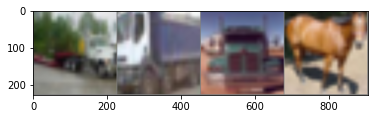

truck truck truck horse


In [93]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [94]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]pip install torchvision
        inputs, labels = data
        print(inputs.shape)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

torch.Size([4, 3, 224, 224])
torch.Size([4, 96, 56, 56])


RuntimeError: ignored